In [1]:
import sys
print(sys.path)
sys.path.append("../KE/")
print(sys.path)

['/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks', '/Users/marcin/.pyenv/versions/3.10.11/lib/python310.zip', '/Users/marcin/.pyenv/versions/3.10.11/lib/python3.10', '/Users/marcin/.pyenv/versions/3.10.11/lib/python3.10/lib-dynload', '', '/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks/venv/lib/python3.10/site-packages']
['/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks', '/Users/marcin/.pyenv/versions/3.10.11/lib/python310.zip', '/Users/marcin/.pyenv/versions/3.10.11/lib/python3.10', '/Users/marcin/.pyenv/versions/3.10.11/lib/python3.10/lib-dynload', '', '/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks/venv/lib/python3.10/site-packages', '../KE/']


In [9]:
!pip install pytorch_tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [37]:
import gzip
import random
import numpy as np
import optuna
import os
import pandas as pd
import sklearn
import shutil
import torch
import time 
from KE.dataclean import tables
from KE.classifier.prepare import split_dataset
from KE.plot import plot
from catboost import Pool
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from optuna import Trial, visualization
from pathlib import Path
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve
)

In [14]:
SEED_VALUE = 62

# Seed for Python's built-in random module
random.seed(SEED_VALUE)

# Seed for NumPy
np.random.seed(SEED_VALUE)

# Seed for TensorFlow
#tf.random.set_seed(SEED_VALUE)

# Seed for PyTorch
torch.manual_seed(SEED_VALUE)
torch.cuda.manual_seed_all(SEED_VALUE)

# Environment-level seed (less common)
#os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)

In [15]:
data = pd.read_csv("../data/merged/merged-kg_edges.tsv", header=0, sep="\t")

data_pairs = data[['subject','object']].drop_duplicates()

# Subset the DataFrame based on the substring in subject
data_pairs_clean = data_pairs[data_pairs['subject'].str.contains('NCBITaxon:')]
# Subset the DataFrame based on the substring in object
data_pairs_clean = data_pairs_clean[data_pairs_clean['object'].str.contains('mediadive.medium:')]

#add closure
data_pairs_chem = data_pairs[data_pairs['subject'].str.contains('NCBITaxon:')]
data_pairs_chem = data_pairs_chem[data_pairs_chem['object'].str.contains('CHEBI:')]

#add closure

data_pairs_go = data_pairs[data_pairs['subject'].str.contains('NCBITaxon:')]
data_pairs_go = data_pairs_go[data_pairs_go['object'].str.contains('GO:')]

data_pairs_rest_all = data_pairs[data_pairs['subject'].str.contains('NCBITaxon:')]
data_pairs_rest = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('carbon_substrate:')]
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('pathways:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('cell_shape_enum:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('data_source:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('ENVO:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('UBERON:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)

data_df_pairs = pd.concat([data_pairs_chem, data_pairs_go], ignore_index=True)
data_df_pairs = pd.concat([data_df_pairs, data_pairs_rest], ignore_index=True)

data_df_pairs['Value'] = 1

# Pivot the old DataFrame to form the new DataFrame structure
data_df = data_df_pairs.pivot(index='subject', columns='object', values='Value')

# Fill NaN values with 0 to indicate no relationship
data_df = data_df.fillna(0)

# Convert the filled NaN values to integers if they were floats after pivot
data_df = data_df.astype(int)

subject_object_mapping = data_pairs_clean.set_index('subject')['object'].to_dict()

# Use the map function to create a new column in 'new_dataframe' from the 'subject' indices
data_df['medium'] = data_df.index.map(subject_object_mapping)

data_df = data_df[data_df['medium'].notna()]

data_df_clean = data_df.groupby('medium').filter(lambda x : len(x)>9)

Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.


In [20]:
import pickle

pickle_filename = 'DeepWalkSkipGramEnsmallen_degreenorm_embedding_2023-11-29_10_24_15.pkl'

with open(pickle_filename, 'rb') as file:
    # Use the 'rb' mode to read in binary mode
    DeepWalkSkipGramEnsmallen_degreenorm_embedding = pickle.load(file)

node_embed = DeepWalkSkipGramEnsmallen_degreenorm_embedding.get_all_node_embedding()[0]
node_embed2 = DeepWalkSkipGramEnsmallen_degreenorm_embedding.get_all_node_embedding()[1]

data_df_clean_join_embed = data_df_clean.join(node_embed, how='left')

data_df_clean_join_embed2 = data_df_clean_join_embed.join(node_embed2, how='left', lsuffix='_left', rsuffix='_right')


In [21]:
X = data_df_clean_join_embed2.drop('medium', axis=1)#data_pairs_clean[['subject']]
y = data_df_clean_join_embed2['medium']

In [25]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)

train_data = Pool(data=X_train, label=y_train, cat_features=[0])
val_data = Pool(data=X_val, label=y_val, cat_features=[0])
test_data = Pool(data=X_test, label=y_test, cat_features=[0])

In [28]:
def train_tab(seed, tabnet_params):
    unsupervised_model = TabNetPretrainer( 
                    seed = seed,
                    n_d=tabnet_params['n_da'], 
                    n_a=tabnet_params['n_da'],
                    n_steps=tabnet_params['n_steps'],
                    n_shared=tabnet_params['n_shared'],
                    optimizer_fn=torch.optim.Adam,
                    optimizer_params=dict(lr=2e-2),
                    mask_type=tabnet_params['mask_type']
    )
    unsupervised_model.fit(
        X_train=X_train.values,
        eval_set=[X_val.values],
        pretraining_ratio=0.8
    )
    tbc = TabNetClassifier(
        seed = seed,
        n_d=tabnet_params['n_da'], 
        n_a=tabnet_params['n_da'],
        #6 - n_d = n_a = 32 = Early stopping occurred at epoch 155 with best_epoch = 135 and best_valid_balanced_accuracy = 0.65672
        n_steps=tabnet_params['n_steps'],
        #7 - n_steps = 6 = Early stopping occurred at epoch 170 with best_epoch = 150 and best_valid_balanced_accuracy = 0.69225
        n_shared=tabnet_params['n_shared'],
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2),
        scheduler_params = {"gamma": 1.0,
                         "step_size":10},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        mask_type=tabnet_params['mask_type'],
        lambda_sparse=tabnet_params['lambda_sparse'],
        clip_value=2.
    )

    tbc.fit(X_train=X_train.values, y_train=y_train,
            eval_set=[(X_train.values, y_train), (X_val.values, y_val)],
            eval_name=['train', 'valid'],
            eval_metric=['balanced_accuracy'],
            from_unsupervised=unsupervised_model,
            patience=tabnet_params['patience'],
            max_epochs=1000,
            batch_size = tabnet_params['batch_size'],
            virtual_batch_size = tabnet_params['virtual batch_size']
           )
    return tbc

In [29]:
%%time
tabnet_params = {'batch_size': 448, 'gamma': 1.0, 'lambda_sparse': 2.943597498374951e-06, 'mask_type': 'entmax', 'n_da': 64, 'n_shared': 1, 'n_steps': 2, 'patience': 22, 'virtual batch_size': 128}

tbc = train_tab(seed=SEED_VALUE, tabnet_params=tabnet_params)

epoch 0  | loss: 427.55064| val_0_unsup_loss_numpy: 59.30796813964844|  0:00:00s
epoch 1  | loss: 183.16379| val_0_unsup_loss_numpy: 479.5760498046875|  0:00:01s
epoch 2  | loss: 75.3174 | val_0_unsup_loss_numpy: 7.372590065002441|  0:00:02s
epoch 3  | loss: 30.13968| val_0_unsup_loss_numpy: 3.872299909591675|  0:00:02s
epoch 4  | loss: 10.85256| val_0_unsup_loss_numpy: 2.655329942703247|  0:00:03s
epoch 5  | loss: 4.17564 | val_0_unsup_loss_numpy: 2.059580087661743|  0:00:04s
epoch 6  | loss: 2.34418 | val_0_unsup_loss_numpy: 1.3919600248336792|  0:00:04s
epoch 7  | loss: 1.76741 | val_0_unsup_loss_numpy: 1.2703200578689575|  0:00:05s
epoch 8  | loss: 1.35595 | val_0_unsup_loss_numpy: 1.235200047492981|  0:00:06s
epoch 9  | loss: 1.24849 | val_0_unsup_loss_numpy: 1.0849100351333618|  0:00:06s
epoch 10 | loss: 1.1113  | val_0_unsup_loss_numpy: 1.0044599771499634|  0:00:07s
epoch 11 | loss: 1.02634 | val_0_unsup_loss_numpy: 1.0759199857711792|  0:00:08s
epoch 12 | loss: 1.00844 | val_0_

Best weights from best epoch are automatically used!
Device used : cpu
Loading weights from unsupervised pretraining


epoch 0  | loss: 5.30811 | train_balanced_accuracy: 0.01277 | valid_balanced_accuracy: 0.00808 |  0:00:00s
epoch 1  | loss: 4.23859 | train_balanced_accuracy: 0.01322 | valid_balanced_accuracy: 0.01347 |  0:00:01s
epoch 2  | loss: 3.83082 | train_balanced_accuracy: 0.01976 | valid_balanced_accuracy: 0.01628 |  0:00:02s
epoch 3  | loss: 3.60347 | train_balanced_accuracy: 0.0253  | valid_balanced_accuracy: 0.02408 |  0:00:02s
epoch 4  | loss: 3.41006 | train_balanced_accuracy: 0.04472 | valid_balanced_accuracy: 0.03663 |  0:00:03s
epoch 5  | loss: 3.20413 | train_balanced_accuracy: 0.05313 | valid_balanced_accuracy: 0.05193 |  0:00:04s
epoch 6  | loss: 2.98933 | train_balanced_accuracy: 0.06426 | valid_balanced_accuracy: 0.06102 |  0:00:04s
epoch 7  | loss: 2.75939 | train_balanced_accuracy: 0.08328 | valid_balanced_accuracy: 0.07822 |  0:00:05s
epoch 8  | loss: 2.53893 | train_balanced_accuracy: 0.12378 | valid_balanced_accuracy: 0.10938 |  0:00:06s
epoch 9  | loss: 2.33482 | train_bala

Best weights from best epoch are automatically used!


CPU times: user 2min 17s, sys: 3min 29s, total: 5min 46s
Wall time: 1min 36s


In [30]:
tbc.save_model('kg_microbe_tabnet.out')

Successfully saved model at kg_microbe_tabnet.out.zip


'kg_microbe_tabnet.out.zip'

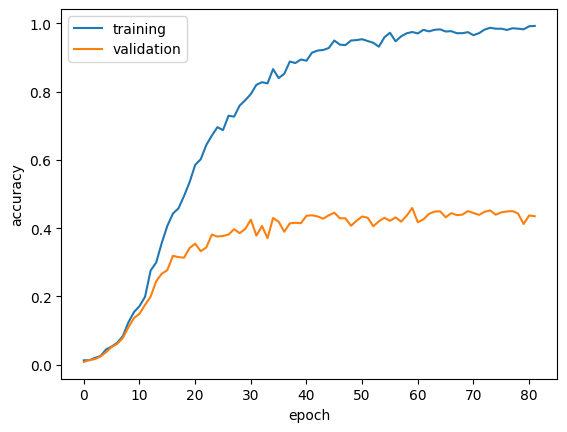

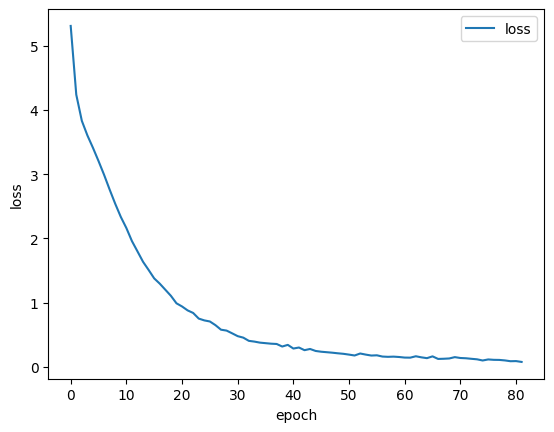

In [33]:
# plot accuracy
plt.plot(tbc.history['train_balanced_accuracy'], label='training')
plt.plot(tbc.history['valid_balanced_accuracy'], label='validation')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc="upper left")
plt.show()
plt.plot(tbc.history['loss'], label='loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc="upper right")
plt.show()

In [38]:
y_pred = tbc.predict(X_test.values)
print(classification_report(y_test, y_pred, digits=3))

                        precision    recall  f1-score   support

    mediadive.medium:1      0.500     0.621     0.554        66
  mediadive.medium:104      0.556     0.556     0.556        18
 mediadive.medium:104b      0.833     0.833     0.833         6
 mediadive.medium:104c      1.000     0.667     0.800         3
mediadive.medium:1076b      0.818     1.000     0.900         9
   mediadive.medium:11      0.667     0.800     0.727        30
  mediadive.medium:110      0.273     0.300     0.286        10
  mediadive.medium:119      0.667     0.500     0.571         4
 mediadive.medium:1203      0.400     1.000     0.571         2
mediadive.medium:1203a      0.000     0.000     0.000         2
  mediadive.medium:141      0.750     0.750     0.750         4
  mediadive.medium:144      0.000     0.000     0.000         2
 mediadive.medium:1523      0.500     0.333     0.400         3
  mediadive.medium:193      0.000     0.000     0.000         2
  mediadive.medium:194      0.000     0

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [39]:
test_acc = accuracy_score(y_pred, y_test)
test_acc

0.5303907380607815

In [42]:
train_pred = tbc.predict(X_train.values)
train_acc = accuracy_score(train_pred,y_train)
train_acc

0.9811776061776062

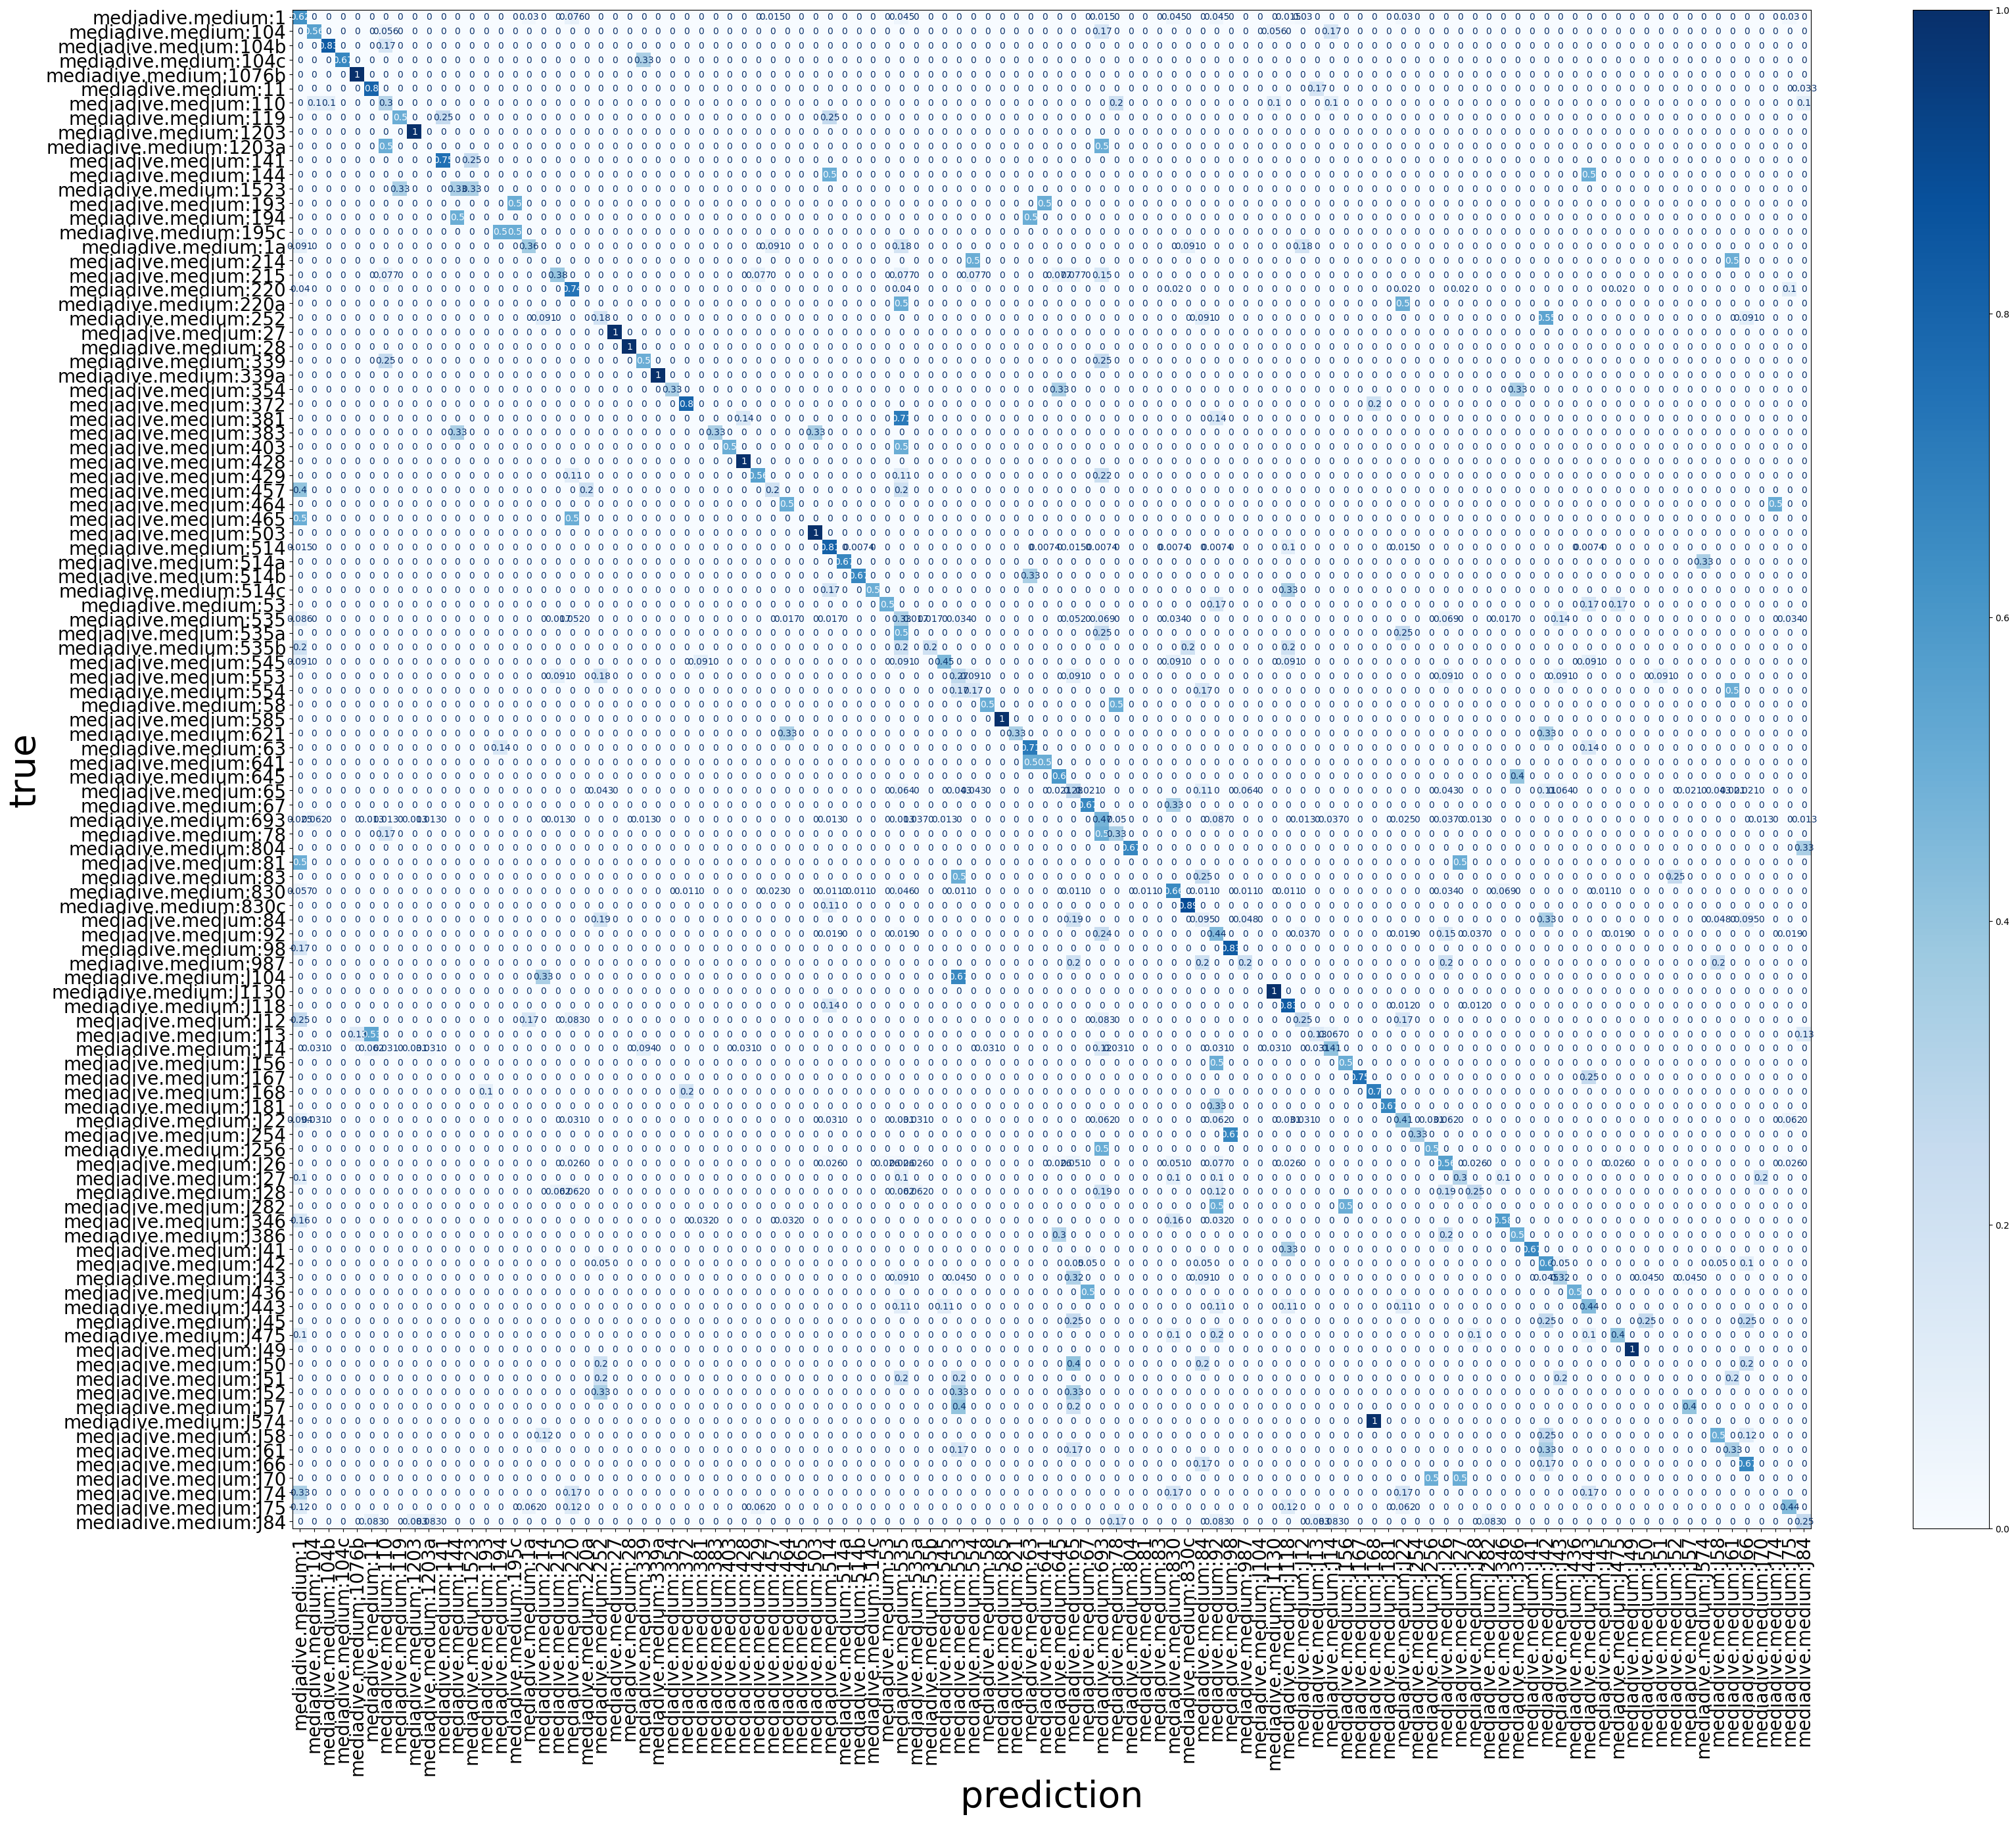

In [44]:
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,cmap=plt.cm.Blues,normalize="true")
fig = plt.gcf()
fig.set_size_inches(40,30)
plt.xticks(rotation=90, fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('prediction', fontsize=40)
plt.ylabel('true', fontsize=40)
fig.savefig('tabnet_wembeddings_confusion_matrix.jpg', dpi=500, bbox_inches='tight')
plt.show()

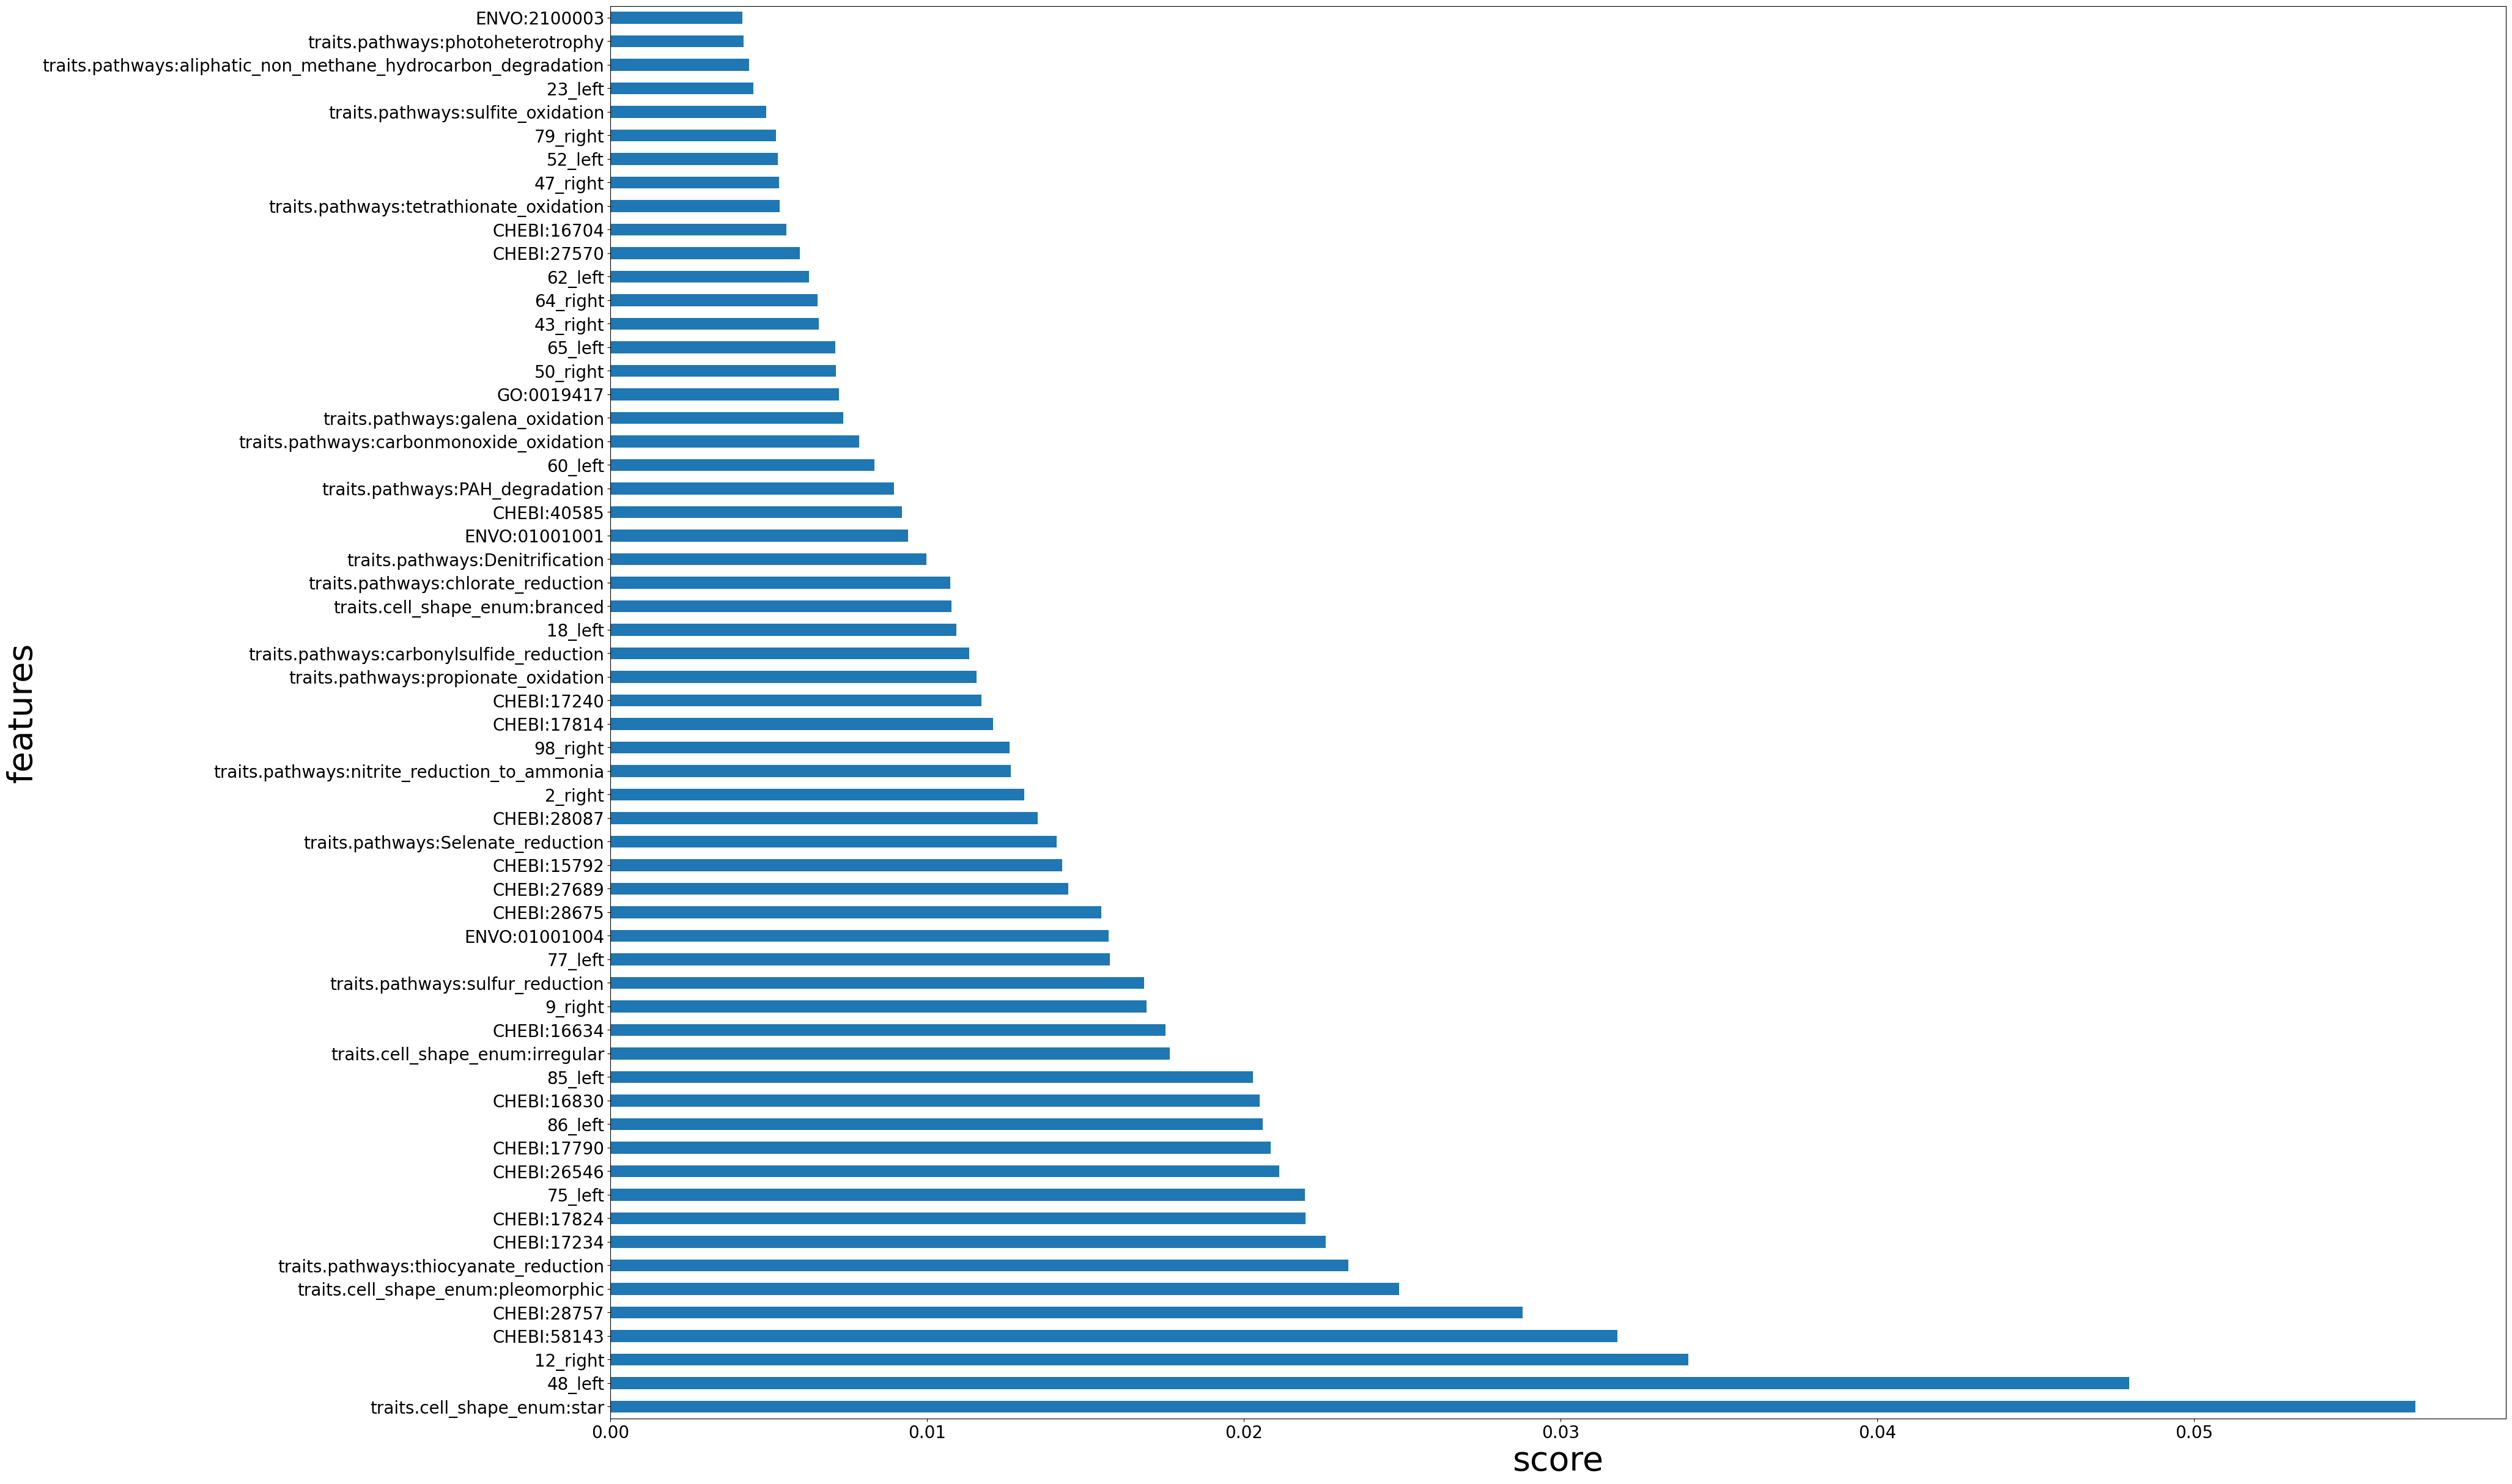

In [51]:
feat = tbc.feature_importances_
feat_importances = pd.Series(tbc.feature_importances_, index=X_train.columns)#[1:
feat_importances.nlargest(60).plot(kind='barh')
fig = plt.gcf()
fig.set_size_inches(40, 30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('score', fontsize=40)
plt.ylabel('features', fontsize=40)
fig.savefig('importance.jpg', dpi=500, bbox_inches='tight')
plt.show()